# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

In [2]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):
v_theta = (np.pi/2)-np.radians(-7.145) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(167.78) # Right Ascension E[0,2pi]

In [3]:
# unit vector in R3. 
# Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Uniform stars and fixed velocity

In [4]:
def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=0)
    return dot
    
#a=[[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
#b=[[0,1,1]]
#adotb=vecdot(a,b)
#print(adotb)

def hola(y):
    return np.where(y == 0, 0, y*np.log(y))
    
print(hola(2))

def alpha(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 6*n1v*(y-1)**3
    return num/den

def gamma(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 3*n1v*((y-1)**2)
    return num/den

I_3 = np.eye(3)
def delta_ij(i, j):
    return 1 if i == j else 0

def GTanalytic_nH1np(v, p, q):
    y = (1-vecdot(p,q))/2 # change to zeta if phi is not 0.
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    alph = alpha(v,p,q)
    gamm = gamma(v,p,q)
    t1 = (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v) * (vecdot(q,p))
    t2 = alph*((vecdot(q,p))**2 + 1) + ( alph/(2*y-1) + 2*gamm*n2v)*(vecdot(q,p))
    t3 = (alph/(2*y-1))*(vecdot(q,p)) + 2*gamm*(2*y-1)*(vecdot(q,p)*vecdot(v,p)) + 2*gamm*(vecdot(v,p))
    return t1+t2+t3 

[ 0 22 26]
1.3862943611198906


## Changing the color of the map according to a function

In [5]:
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)
print(unit_vector)
print(np.dot(unit_vector,unit_vector))

[ 0.52756955 -0.19498536  0.82683195]
1.0


dir shape: (3, 19200)
v shape: (3, 1)
vm shape: (3, 1)


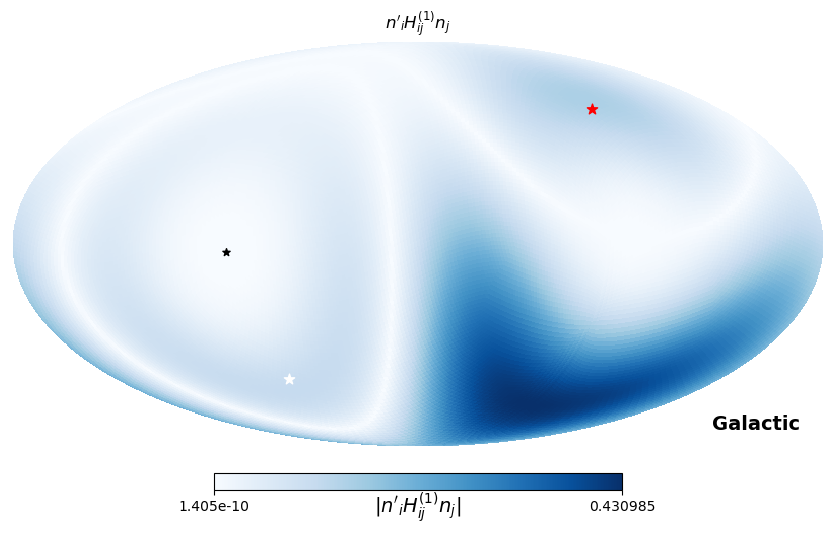

In [16]:
nside = 40 # Kernel dies with 50 and larger numbers! :(
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(theta,phi) #.T#.reshape(npix,3)

v = skyvec(v_theta, v_phi).reshape(3,1)
#vn = skyvec(v_theta, v_phi).reshape(3,1) # Same direction as velocity 
#vn = skyvec(v_theta, v_phi+0.1).reshape(3,1) # Close to the velocity
#vn = -1.*np.array(v) # Opposite to the velocity
vn = unit_vector.reshape(3,1) # Random position
vs = -1.*np.array(v)
thetaVn, phiVn = hp.vec2ang(vn)
thetaVs, phiVs = hp.vec2ang(vs)


print('dir shape:',np.shape(dir))
print('v shape:',np.shape(v))
print('vm shape:',np.shape(vn))

Map_nH1np = GTanalytic_nH1np(v,dir,vn)

hp.mollview(abs(Map_nH1np),title=r"$n'_{i} H^{(1)}_{ij} n_{j}$",cmap='Blues',cbar=True,coord=['E','G'], unit=r"$|n'_{i} H^{(1)}_{ij} n_{j}|$")
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r',coord=['E','G'])
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='w',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k',coord=['E','G']) 

#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/nH(1)n/nHn_Vopposite.pdf')#,bbox_inches='tight')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/nH(1)n/nHn_RandomStar_fixed.pdf')
